**2D Patches Segmentation with a UNet Architecture**





In [1]:
import os
import numpy as np
class UnetConfig(object):
    IMAGE_W = 64
    IMAGE_H = 64
    IMAGE_C = 1
    kernel_size=3
    n_levels = 4
    n_blocks=2
    pooling_size=2
    out_channels=1
    initial_features=32
    epochs = 100
    patch_size = 64
    batch_size = 64
 
    def displayConfiguration(self):
        """Display Configuration values."""
        print("\nConfigurations:")
        for a in dir(self):
            if not a.startswith("__") and not callable(getattr(self, a)):
                print("{:30} {}".format(a, getattr(self, a)))
        print("\n")

In [48]:
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
import os
import nibabel as nib
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import math
import numpy as np
from keras.models import load_model
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

class UNet(object):
    
    def __init__(self, config=UnetConfig()):
        self.config = config
        self.model = self.build_model_Unet()
    
    def normalizeImageIntensityRange(self,img):
      RANGE = np.max(img) - np.min(img)
      img[img < np.min(img)] = np.min(img)
      img[img > np.max(img)] = np.max(img)
      if( RANGE != 0):
        return (img - np.min(img)) /RANGE,1
      else:
        return img, 0


    def build_model_Unet(self):

        inputs = keras.layers.Input(shape=(self.config.IMAGE_H, self.config.IMAGE_W, self.config.IMAGE_C))    
        x = inputs
        convpars = dict(kernel_size=3, activation='relu', padding='same')
            #downsampling (context information)
        skips = {}
        for level in range(self.config.n_levels):
            for _ in range(self.config.n_blocks):
                x = keras.layers.Conv2D(self.config.initial_features * 2 ** level, **convpars)(x) #convblock
            if level < self.config.n_levels - 1:
                skips[level] = x #skipconnection
                x = keras.layers.MaxPool2D(self.config.pooling_size)(x) #Maxpooling
                
        # upsampling (localization information)
        for level in reversed(range(self.config.n_levels-1)): #reversed pour commencer par la fin
            x = keras.layers.Conv2DTranspose(self.config.initial_features * 2 ** level, strides=self.config.pooling_size, **convpars)(x)
            x = keras.layers.Concatenate()([x, skips[level]]) #Concaténation
            for _ in range(self.config.n_blocks):
                x = keras.layers.Conv2D(self.config.initial_features * 2 ** level, **convpars)(x)
                
        # output
        activation = 'sigmoid' if self.config.out_channels == 1 else 'softmax'
        x = keras.layers.Conv2D(self.config.out_channels, kernel_size=1, activation=activation, padding='same')(x)

        model = keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{self.config.n_levels}-F{self.config.initial_features}')
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        return model


    def train(self):
        model = self.model
            
        img_patches = []
        mask_patches = []
        img_patches_val = []
        mask_patches_val = []
        patch_size = self.config.patch_size

        for cpt in range (13, len(os.listdir('/content/drive/My Drive/ds102_R2.0.0/')) ):

          ImagePath = f'/content/drive/My Drive/ds102_R2.0.0/sub-{cpt}/anat/sub-{cpt}_T1w_brain.nii.gz'
          MaskPath = f'/content/drive/My Drive/ds102_R2.0.0/sub-{cpt}/anat/sub-{cpt}_T1w_brain_pve_1.nii.gz' 
          
          Image = nib.load(ImagePath).get_fdata()
          Mask = nib.load(MaskPath).get_fdata()

          for i in range (0, Image.shape[1]):
              ImageSlice = Image[:,i,:]
              MaskSlice = Mask[:,i,:]
              ImageSliceResize= cv2.resize(ImageSlice, (256,256))
              MaskSliceResize = cv2.resize(MaskSlice, (256,256))
              
              I, flag = UNet.normalizeImageIntensityRange(self, ImageSliceResize)
              if flag!=0:
                ImageSliceResize = I
             
              M, flag =  UNet.normalizeImageIntensityRange(self, MaskSliceResize)
              if flag!=0:
                MaskSliceResize = M

              if cpt<24:

                for k in range (0, ImageSliceResize.shape[0], patch_size):
                  for j in range(0, ImageSliceResize.shape[1], patch_size):
                    patch_image = cv2.resize(ImageSliceResize[k:k+patch_size, j:j+patch_size], (patch_size, patch_size))
                    patch_mask = cv2.resize(MaskSliceResize[k:k+patch_size, j:j+patch_size], (patch_size, patch_size))
                    
                    if(np.max(patch_image)>0):
                      img_patches.append(patch_image)
                      mask_patches.append(patch_mask)
                      #if (k == j):
                       # zoomin(patch_image, patch_mask, img_patches, mask_patches)
              else:
                for k in range (0, ImageSliceResize.shape[0], patch_size):
                  for j in range(0, ImageSliceResize.shape[1], patch_size):
                    patch_image = cv2.resize(ImageSliceResize[k:k+patch_size, j:j+patch_size], (patch_size, patch_size))
                    patch_mask = cv2.resize(MaskSliceResize[k:k+patch_size, j:j+patch_size], (patch_size, patch_size))
                    img_patches_val.append(patch_image)
                    mask_patches_val.append(patch_mask)

        X_train = np.zeros((len(mask_patches),patch_size,patch_size,1))
        Y_train = np.zeros((len(mask_patches),patch_size,patch_size,1))
        for i in range(0,len(mask_patches)):
          X_train[i,:,:,0] = img_patches[i]
          Y_train[i,:,:,0] = mask_patches[i]

        X_val = np.zeros((len(mask_patches_val),patch_size,patch_size,1))
        Y_val = np.zeros((len(mask_patches_val),patch_size,patch_size,1))
        for i in range(0,len(mask_patches_val)):
          X_val[i,:,:,0] = img_patches_val[i]
          Y_val[i,:,:,0] = mask_patches_val[i]

        with tf.device('/device:GPU:0'):
          model.fit(X_train, Y_train, epochs = self.config.epochs, batch_size = self.config.batch_size, validation_data = (X_val, Y_val))
    
    def save_model(self,name):
      return self.model.save(name)

    def predict(self,ImagePath, MaskPath, slices, modelpath, load_model1 = False):
        Image = nib.load(ImagePath).get_fdata()
        Mask = nib.load(MaskPath).get_fdata()

        ImageSlice = Image[:,slices,:]
        MaskSlice = Mask[:,slices,:]
        ImageSliceResize= cv2.resize(ImageSlice, (256,256))
        MaskSliceResize = cv2.resize(MaskSlice, (256,256))

        I, flag =  UNet.normalizeImageIntensityRange(self, ImageSliceResize)
        if flag!=0:
          ImageSliceResize = I
        
        img_patches = []
        mask_patches = []
        patch_size = self.config.patch_size

        for k in range (0, ImageSliceResize.shape[0], patch_size):
          for j in range(0, ImageSliceResize.shape[1], patch_size):
            patch_image = cv2.resize(ImageSliceResize[k:k+patch_size, j:j+patch_size], (patch_size, patch_size))
            patch_mask = cv2.resize(MaskSliceResize[k:k+patch_size, j:j+patch_size], (patch_size, patch_size))
            img_patches.append(patch_image)
            mask_patches.append(patch_mask)

        X_test = np.zeros((len(mask_patches),patch_size,patch_size,1))
        Y_test = np.zeros((len(mask_patches),patch_size,patch_size,1))

        for i in range(0,len(mask_patches)):
          X_test[i,:,:,0] = img_patches[i]
          Y_test[i,:,:,0] = mask_patches[i]

        if (load_model1 == False):
          result=self.model.predict(X_test)
        else:
          model2 = load_model( modelpath)
          result=model2.predict(X_test)
        return result,img_patches, mask_patches

    def show_predict(self,ImagePath, MaskPath, slices, num_patch,  modelpath, load_model1 = False, show_rgb = False):
      Y_prediction,img_patches, mask_patches = UNet.predict(self, ImagePath, MaskPath, slices, modelpath, load_model1)
      final_pred = np.zeros((16,self.config.patch_size,self.config.patch_size))
      final_pred = Y_prediction[:,:,:,0]
      final_pred[final_pred>0.5] = 1
      title = ["Input patch", "True Mask", "Mask Predicted"]
      
      plt.figure(figsize = (10,10))
      plt.subplot(1,3,1)
      plt.title(title[0],fontdict = {'fontsize' : 18})
      plt.imshow(img_patches[num_patch], cmap = 'gray')
      plt.subplot(1,3,2)
      plt.title(title[1],fontdict = {'fontsize' : 18})
      plt.imshow(mask_patches[num_patch], cmap = 'gray')
      plt.subplot(1,3,3)
      plt.title(title[2],fontdict = {'fontsize' : 18})
      plt.imshow(final_pred[num_patch], cmap = 'gray')
      plt.show()

      if show_rgb: 
        rgb = np.zeros((self.config.patch_size,self.config.patch_size,3))
        rgb[mask_patches[num_patch]>0.5] = (0,0,1)

        pred_rgb = np.zeros((self.config.patch_size,self.config.patch_size,3))
        pred_rgb[final_pred[num_patch]>0.5] = (0,0, 1)

        title = ["Input patch", "True Mask", "Mask Predicted"]
        plt.figure(figsize = (10,10))
        plt.subplot(1,3,1)
        plt.title(title[0],fontdict = {'fontsize' : 18})
        plt.imshow(img_patches[num_patch], cmap = 'gray')
        plt.subplot(1,3,2)
        plt.title(title[1],fontdict = {'fontsize' : 18})
        plt.imshow(rgb, cmap = 'gray')
        plt.subplot(1,3,3)
        plt.title(title[2],fontdict = {'fontsize' : 18})
        plt.imshow(pred_rgb, cmap = 'gray')
        plt.show()
        UNet.get_f1(self, rgb, pred_rgb)
        return rgb, pred_rgb
      return final_pred

    def show_predict_3classes(self,ImagePath, MaskPath, MaskPath1, MaskPath2, slices, num_patch,  modelpath_csf, modelpath_gm, modelpath_wm):

      Y_prediction_csf,img_patches, mask_patches_csf = UNet.predict(self, ImagePath, MaskPath, slices,  modelpath_csf, True)
      Y_prediction_gm,img_patches, mask_patches_gm = UNet.predict(self, ImagePath, MaskPath1, slices,  modelpath_gm, True)
      Y_prediction_wm,img_patches, mask_patches_wm = UNet.predict(self, ImagePath, MaskPath2, slices,  modelpath_wm, True)

      final_pred_csf = np.zeros((16,self.config.patch_size,self.config.patch_size))
      final_pred_csf = Y_prediction_csf[:,:,:,0]

      final_pred_gm = np.zeros((16,self.config.patch_size,self.config.patch_size))
      final_pred_gm = Y_prediction_gm[:,:,:,0]

      final_pred_wm = np.zeros((16,self.config.patch_size,self.config.patch_size))
      final_pred_wm = Y_prediction_wm[:,:,:,0]

      rgb = np.zeros((self.config.patch_size,self.config.patch_size,3))
      rgb[mask_patches_csf[num_patch]>0.5] = (1,0,0)
      rgb[mask_patches_gm[num_patch]>0.5] = (0,1,0)
      rgb[mask_patches_wm[num_patch]>0.5] = (0,0,1)

      pred_rgb = np.zeros((self.config.patch_size,self.config.patch_size,3))
      pred_rgb[final_pred_wm[num_patch]>0.5] = (1,0,0)
      pred_rgb[final_pred_csf[num_patch]>0.5] = (0,1,0)
      pred_rgb[final_pred_gm[num_patch]>0.5] = (0,0, 1)

      title = ["Input patch", "True Mask", "Mask Predicted"]
      plt.figure(figsize = (10,10))
      plt.subplot(1,3,1)
      plt.title(title[0],fontdict = {'fontsize' : 18})
      plt.imshow(img_patches[num_patch], cmap = 'gray')
      plt.subplot(1,3,2)
      plt.title(title[1],fontdict = {'fontsize' : 18})
      plt.imshow(rgb, cmap = 'gray')
      plt.subplot(1,3,3)
      plt.title(title[2],fontdict = {'fontsize' : 18})
      plt.imshow(pred_rgb, cmap = 'gray')
      plt.show()
      UNet.get_f1(self, rgb, pred_rgb)
      return final_pred_csf, final_pred_wm, final_pred_gm
    
    def get_f1(self, y_true, y_pred): #taken from old keras source code
      true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
      possible_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true, 0, 1)))
      predicted_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred, 0, 1)))
      precision = true_positives / (predicted_positives + keras.backend.epsilon())
      recall = true_positives / (possible_positives + keras.backend.epsilon())
      f1_val = 2*(precision*recall)/(precision+recall+keras.backend.epsilon())
      print(f1_val)
      return f1_val

    def reconstruction(self, final_pred ):
      pred_rec = np.zeros((256,256))
      cpt = 0
      for i in range(1,5):
        for j in range(1,5):
          pred_rec[64*(i-1):64*i,64*(j-1):64*j] = final_pred[cpt]
          cpt = cpt +1
      plt.figure(figsize=(10,10))
      plt.imshow(pred_rec, cmap ='gray')
      plt.show()
      return pred_rec









Found GPU at: /device:GPU:0


**TRAINING THE NETWORK**

In [ ]:
config=UnetConfig()

unet=UNet(config=config)

unet.train()
unet.save_model('/content/drive/My Drive/model_class.h5')

In [49]:

config=UnetConfig()
unet=UNet(config=config)

Model: "UNET-L4-F32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 64, 64, 32)   320         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_107 (Conv2D)             (None, 64, 64, 32)   9248        conv2d_106[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 32, 32, 32)   0           conv2d_107[0][0]                 
________________________________________________________________________________________

**DATA PATH FOR TESTING**

In [ ]:
ImagePath = '/content/drive/My Drive/0050458/001_brain.nii.gz'
MaskPath = '/content/drive/My Drive/0050458/001_brain_pve_2.nii.gz' 
MaskPath1 = '/content/drive/My Drive/0050458/001_brain_pve_1.nii.gz' 
MaskPath2 = '/content/drive/My Drive/0050458/001_brain_pve_0.nii.gz'

**PREDICTION OF ONE PATCH FOR 3 TISSUES**

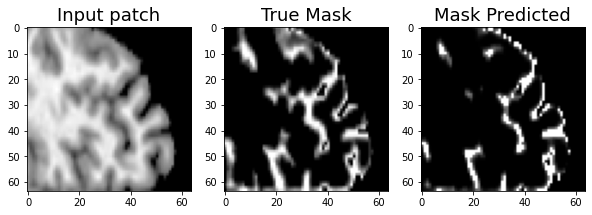

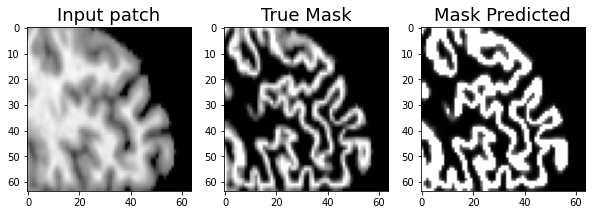

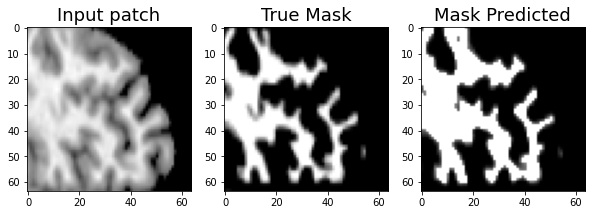

In [50]:
Y_prediction = unet.show_predict(ImagePath, MaskPath2,100,6,'/content/drive/My Drive/res_u_class_pve0.h5', True, False)

Y_prediction = unet.show_predict(ImagePath, MaskPath1,100,6,'/content/drive/My Drive/model_resunet_class_pve1.h5', True, False)

Y_prediction = unet.show_predict(ImagePath, MaskPath,100,6, '/content/drive/My Drive/res_u_class_pve2.h5', True, False)


**FULL PREDICTION OF A PATCH IN RGB**

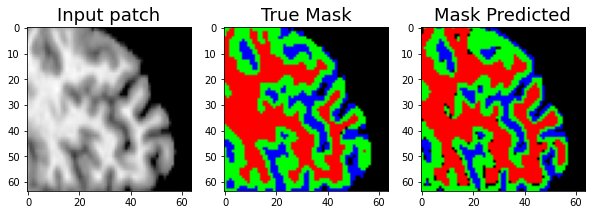

tf.Tensor(0.8430982617909574, shape=(), dtype=float64)


In [51]:

fp1,fp2,fp3 = unet.show_predict_3classes(ImagePath, MaskPath, MaskPath1, MaskPath2, 100, 6, '/content/drive/My Drive/Segmentationpatchpve0_normalized.h5', '/content/drive/My Drive/Segmentationpatchpve1_normalized.h5', '/content/drive/My Drive/Segmentationpatchpve2_normalized.h5')
